# Finetune ResNet50


With 1000 x 400 melspectrogram images normalized on teh train set with online data augmentation (stochastic Gaussian noise), with a lower maximum standard deviation value


In [1]:
import sys
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import time

In [2]:
# Get the absolute path to the project root without relying on __file__
notebook_path = os.getcwd()  # Gets current working directory
project_root = os.path.abspath(os.path.join(notebook_path, "../.."))
sys.path.insert(0, project_root)

In [3]:
print(torch.__version__)
print(torch.cuda.is_available())

2.5.1+cu121
True


Set the seed for reproducability


In [4]:
random_seed = 42

torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

if (torch.cuda.is_available()):
    torch.cuda.manual_seed(random_seed)

Set some constant strings


In [5]:
FINETUNED_MODEL = 'resnet50_augmented_stochastic_normalized'

train_csv = '../../../data/melspectrogram_train_dataset.csv'
test_csv = '../../../data/melspectrogram_test_dataset.csv'
val_csv = '../../../data/melspectrogram_val_dataset.csv'
root_dir = '../../../data/'

Custom dataset class for loading the mel spectrogram images


In [6]:
from datasets.MelspectrogramDataset import MelSpectrogramDataset

Define the training function


In [7]:
def train(model, trainloader, criterion, optimizer, device):
    train_loss = 0.0
    train_total = 0
    train_correct = 0

    # train mode
    model.train()

    epoch_start = time.time()
    pbar = tqdm(enumerate(trainloader), total=len(
        trainloader), desc="Training")

    for i, (inputs, labels) in pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update training loss
        train_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        # Calculate time metrics
        elapsed = time.time() - epoch_start
        progress = (i + 1) / len(trainloader)
        eta = elapsed / progress - elapsed

        # Update progress bar with current loss and ETA
        pbar.set_postfix({
            "Loss": f"{loss.item()}",
            "Elapsed": f"{elapsed:.4f}s",
            "ETA": f"{eta:.4f}s"
        })

    train_loss = train_loss / len(trainloader)
    train_accuracy = train_correct / train_total * 100

    return model, train_loss, train_accuracy

Define the validation function


In [8]:
def validate(model, valloader, criterion, device):
    val_loss = 0.0
    val_total = 0
    val_correct = 0

    # Switch to evaluation mode
    model.eval()

    epoch_start = time.time()
    pbar = tqdm(enumerate(valloader), total=len(
        valloader), desc="Validating")

    with torch.no_grad():
        for i, (inputs, labels) in pbar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Update test loss
            val_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            # Calculate time metrics
            elapsed = time.time() - epoch_start
            progress = (i + 1) / len(valloader)
            eta = elapsed / progress - elapsed

            # Update progress bar with current loss and ETA
            pbar.set_postfix({
                "Loss": f"{loss.item()}",
                "Elapsed": f"{elapsed:.4f}s",
                "ETA": f"{eta:.4f}s"
            })

    val_loss = val_loss / len(valloader)
    val_accuracy = val_correct / val_total * 100

    return val_loss, val_accuracy

Define what happens in each epoch


In [9]:
def train_epochs(model, trainloader, valloader, criterion, optimizer, device, num_epochs):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    best_accuracy = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        epoch_start = time.time()

        model, train_loss, train_accuracy = train(
            model, trainloader, criterion, optimizer, device)
        val_loss, val_accuracy = validate(
            model, valloader, criterion, device)

        epoch_elapsed = time.time() - epoch_start
        print(f"Epoch {epoch+1} completed in {epoch_elapsed:.4f}s")
        print(f'Train Loss: {train_loss} - Train Accuracy: {train_accuracy}')
        print(
            f'Validation Loss: {val_loss} - Validation Accuracy: {val_accuracy}')
        print()

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Check if current model is best performing using test_accuracy
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), f'best_{FINETUNED_MODEL}.pt')
            checkpoint = {
                'epoch': epoch + 1,
                'train_losses': train_losses,
                'train_accuracies': train_accuracies,
                'val_losses': val_losses,
                'val_accuracies': val_accuracies,
            }
            torch.save(checkpoint, f'best_{FINETUNED_MODEL}_checkpoint.pt')

    return model, train_losses, train_accuracies, val_losses, val_accuracies

Plot the loss and accuracy graphs


In [10]:
def plot_loss(train_losses, val_losses):
    plt.figure()
    plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
    plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [11]:
def plot_accuracy(train_accuracies, val_accuracies):
    plt.figure()
    plt.plot(range(len(train_accuracies)),
             train_accuracies, label='Training Accuracy')
    plt.plot(range(len(val_accuracies)),
             val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

Define the model


In [12]:
model = models.resnet50(pretrained=True)

c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\myenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\myenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Prepare for fine-tuning


In [13]:
# Number of classes
num_classes = 9

# Freeze all layers except the last fully connected layer
for param in model.parameters():
    param.requires_grad = False  # Freeze all layers

# Modify final fully connected layer according to number of classes
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_classes)
# print("Modified model")
# print(model)

# Unfreeze the final fully connected layer so it will be trained
for param in model.fc.parameters():
    param.requires_grad = True

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Define a class to add Gaussian noise to the mel spectrogram images for online data augmentation


In [14]:
from data_augmentation.AddGaussianNoiseStochastic import AddGaussianNoiseStochastic

Compute the mean and standard deviation of the train dataset


In [15]:
def compute_mean_std(dataset, batch_size=128, num_workers=8):
    loader = DataLoader(dataset, batch_size=batch_size,
                        num_workers=num_workers, shuffle=False)
    mean = 0.0
    std = 0.0
    total_samples = 0

    for data, _ in loader:
        batch_samples = data.size(0)
        # flatten H and W dimensions
        data = data.view(batch_samples, data.size(1), -1)
        mean += data.mean(2).sum(0)
        std += data.std(2).sum(0)
        total_samples += batch_samples

    mean /= total_samples
    std /= total_samples
    return mean, std


# Temporary transform: only apply Resize and ToTensor (no normalization)
temp_transform = transforms.Compose([
    # Resize the Mel spectrogram to 224x224, suitable for ResNet50
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Create a temporary dataset to compute statistics
temp_dataset = MelSpectrogramDataset(
    csv_file=train_csv, root_dir=root_dir, transform=temp_transform)
mean, std = compute_mean_std(temp_dataset)
print("Computed Mean:", mean)
print("Computed Std:", std)

Computed Mean: tensor([0.2126, 0.0765, 0.1826])
Computed Std: tensor([0.2794, 0.1221, 0.1852])


Define the learning rate, criterion, optimizer, transformations, and number of epochs


In [16]:
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Define train transformations, also the online data augmentation
train_transform = transforms.Compose([
    # Resize the Mel spectrogram to 224x224, suitable for ResNet50
    transforms.Resize((224, 224)),
    transforms.ToTensor(),          # Convert to Tensor
    AddGaussianNoiseStochastic(mean=0.0, std_range=(0.0, 0.03), p=0.5
                               ),  # Online noise augmentation
    # Normalize to the train set
    transforms.Normalize(mean=mean.tolist(), std=std.tolist())
])

# Define test transformations for both validation and test sets
test_transform = transforms.Compose([
    # Resize the Mel spectrogram to 224x224, suitable for ResNet50
    transforms.Resize((224, 224)),
    transforms.ToTensor(),          # Convert to Tensor
    # Normalize to the train set
    transforms.Normalize(mean=mean.tolist(), std=std.tolist())
])

epochs = 25

Execute the fine-tuning


Mapping from Emotion to Number: {'Anger': 0, 'Bored': 1, 'Disgust': 2, 'Fear': 3, 'Happy': 4, 'Neutral': 5, 'Question': 6, 'Sad': 7, 'Surprise': 8}
Model is on: cuda:0
Epoch 1/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.66it/s, Loss=1.7322863340377808, Elapsed=21.1604s, ETA=0.0000s] 


Epoch 1 completed in 74.4626s
Train Loss: 1.4693915396067447 - Train Accuracy: 42.08181633160715
Validation Loss: 1.3796498680114746 - Validation Accuracy: 46.485859012241455

Epoch 2/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.65it/s, Loss=1.8506895303726196, Elapsed=20.7163s, ETA=0.0000s] 


Epoch 2 completed in 74.4228s
Train Loss: 1.3293322111140786 - Train Accuracy: 47.83247778204925
Validation Loss: 1.2988140424092611 - Validation Accuracy: 49.51456310679612

Epoch 3/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.79it/s, Loss=1.9645322561264038, Elapsed=20.7400s, ETA=0.0000s] 


Epoch 3 completed in 74.0234s
Train Loss: 1.2871791420644418 - Train Accuracy: 49.64609574636485
Validation Loss: 1.3041731468836466 - Validation Accuracy: 49.05023216547066

Epoch 4/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.75it/s, Loss=1.7532501220703125, Elapsed=20.6545s, ETA=0.0000s] 


Epoch 4 completed in 73.8395s
Train Loss: 1.2780993684178832 - Train Accuracy: 49.96042604192578
Validation Loss: 1.2753956190745035 - Validation Accuracy: 51.26635711270578

Epoch 5/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.77it/s, Loss=1.6647111177444458, Elapsed=20.8811s, ETA=0.0000s] 


Epoch 5 completed in 74.4053s
Train Loss: 1.2529551435068162 - Train Accuracy: 51.35116799710545
Validation Loss: 1.2840356953938803 - Validation Accuracy: 49.609539890249046

Epoch 6/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.67it/s, Loss=1.7000991106033325, Elapsed=23.2834s, ETA=0.0000s]  


Epoch 6 completed in 77.1678s
Train Loss: 1.2406787205638223 - Train Accuracy: 51.6315777571742
Validation Loss: 1.2491357135772705 - Validation Accuracy: 52.100042211903755

Epoch 7/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.67it/s, Loss=1.4992649555206299, Elapsed=20.8442s, ETA=0.0000s] 


Epoch 7 completed in 74.2721s
Train Loss: 1.228077206308442 - Train Accuracy: 52.15847674181949
Validation Loss: 1.239649200439453 - Validation Accuracy: 52.23723089911355

Epoch 8/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.66it/s, Loss=1.8803893327713013, Elapsed=21.9341s, ETA=0.0000s]  


Epoch 8 completed in 75.5529s
Train Loss: 1.2281067869222233 - Train Accuracy: 52.07254471857262
Validation Loss: 1.2320015986760458 - Validation Accuracy: 52.226677923174336

Epoch 9/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.58it/s, Loss=1.5650451183319092, Elapsed=20.8776s, ETA=0.0000s] 


Epoch 9 completed in 74.4829s
Train Loss: 1.2111914405933004 - Train Accuracy: 52.96578548653355
Validation Loss: 1.2027824942270915 - Validation Accuracy: 53.535246939636984

Epoch 10/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.55it/s, Loss=1.8215022087097168, Elapsed=20.9220s, ETA=0.0000s] 


Epoch 10 completed in 74.8088s
Train Loss: 1.2023592226078055 - Train Accuracy: 53.4474570905226
Validation Loss: 1.207247314453125 - Validation Accuracy: 53.957365977205576

Epoch 11/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.67it/s, Loss=1.515612006187439, Elapsed=20.8595s, ETA=0.0000s]  


Epoch 11 completed in 74.7658s
Train Loss: 1.202536070277925 - Train Accuracy: 53.27333167499604
Validation Loss: 1.2191670767466227 - Validation Accuracy: 53.324187420852674

Epoch 12/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.52it/s, Loss=1.7532374858856201, Elapsed=21.0947s, ETA=0.0000s] 


Epoch 12 completed in 74.7376s
Train Loss: 1.1914498111760685 - Train Accuracy: 53.750480540919476
Validation Loss: 1.217019151051839 - Validation Accuracy: 52.81764457577037

Epoch 13/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.63it/s, Loss=1.7110607624053955, Elapsed=20.9057s, ETA=0.0000s] 


Epoch 13 completed in 74.3970s
Train Loss: 1.1869800340578047 - Train Accuracy: 53.99018565839759
Validation Loss: 1.1944038677215576 - Validation Accuracy: 54.20008442380752

Epoch 14/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.60it/s, Loss=1.8069801330566406, Elapsed=20.9697s, ETA=0.0000s] 


Epoch 14 completed in 74.5517s
Train Loss: 1.1825839882296634 - Train Accuracy: 54.110038217136655
Validation Loss: 1.2086193434397379 - Validation Accuracy: 53.63022372308991

Epoch 15/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.57it/s, Loss=1.4186148643493652, Elapsed=20.8517s, ETA=0.0000s] 


Epoch 15 completed in 74.4987s
Train Loss: 1.1793612889471772 - Train Accuracy: 54.621107618552266
Validation Loss: 1.1784441216786703 - Validation Accuracy: 54.358379062895736

Epoch 16/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.65it/s, Loss=1.564270257949829, Elapsed=20.7308s, ETA=0.0000s]  


Epoch 16 completed in 74.2206s
Train Loss: 1.173351843577589 - Train Accuracy: 54.664073630175714
Validation Loss: 1.2013840508460998 - Validation Accuracy: 53.29252849303504

Epoch 17/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.57it/s, Loss=1.5557512044906616, Elapsed=20.8920s, ETA=0.0000s] 


Epoch 17 completed in 74.1874s
Train Loss: 1.1698379435635715 - Train Accuracy: 54.99649487799913
Validation Loss: 1.172959181467692 - Validation Accuracy: 54.63275643731532

Epoch 18/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.77it/s, Loss=1.6719352006912231, Elapsed=20.8556s, ETA=0.0000s] 


Epoch 18 completed in 74.5827s
Train Loss: 1.1675385098925906 - Train Accuracy: 54.56909613079759
Validation Loss: 1.175192944208781 - Validation Accuracy: 55.20261713803293

Epoch 19/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.80it/s, Loss=1.643389344215393, Elapsed=20.9025s, ETA=0.0000s]  


Epoch 19 completed in 73.7394s
Train Loss: 1.1605086347271252 - Train Accuracy: 55.26785916193664
Validation Loss: 1.2000891613960265 - Validation Accuracy: 54.50612072604475

Epoch 20/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.73it/s, Loss=1.5658116340637207, Elapsed=20.7736s, ETA=0.0000s] 


Epoch 20 completed in 73.5133s
Train Loss: 1.1590343222797261 - Train Accuracy: 55.14348386513195
Validation Loss: 1.175405662059784 - Validation Accuracy: 54.78049810046433

Epoch 21/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.66it/s, Loss=1.440836787223816, Elapsed=21.2765s, ETA=0.0000s]   


Epoch 21 completed in 74.1595s
Train Loss: 1.1607036688768795 - Train Accuracy: 54.8969946405554
Validation Loss: 1.1773238150278726 - Validation Accuracy: 54.76994512452512

Epoch 22/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.68it/s, Loss=1.8121376037597656, Elapsed=20.8388s, ETA=0.0000s] 


Epoch 22 completed in 74.2739s
Train Loss: 1.1478619749490926 - Train Accuracy: 55.99149725243663
Validation Loss: 1.2315588347117106 - Validation Accuracy: 51.54073448712537

Epoch 23/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.64it/s, Loss=1.1336321830749512, Elapsed=20.8130s, ETA=0.0000s] 


Epoch 23 completed in 74.3170s
Train Loss: 1.1433114183775952 - Train Accuracy: 55.778928563352245
Validation Loss: 1.180180898507436 - Validation Accuracy: 54.30561418319966

Epoch 24/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.58it/s, Loss=1.5540399551391602, Elapsed=20.9740s, ETA=0.0000s] 


Epoch 24 completed in 74.1969s
Train Loss: 1.148680638715711 - Train Accuracy: 55.53922344587413
Validation Loss: 1.172536591688792 - Validation Accuracy: 55.20261713803293

Epoch 25/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.69it/s, Loss=1.2817111015319824, Elapsed=20.6704s, ETA=0.0000s] 

Epoch 25 completed in 74.1949s
Train Loss: 1.1393073624958192 - Train Accuracy: 56.210850048619434
Validation Loss: 1.1763224029541015 - Validation Accuracy: 54.85436893203883



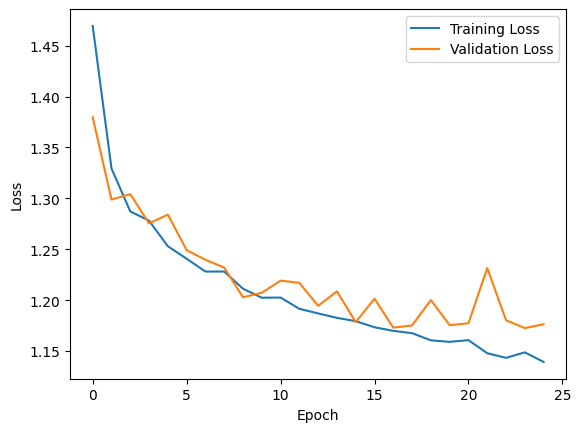

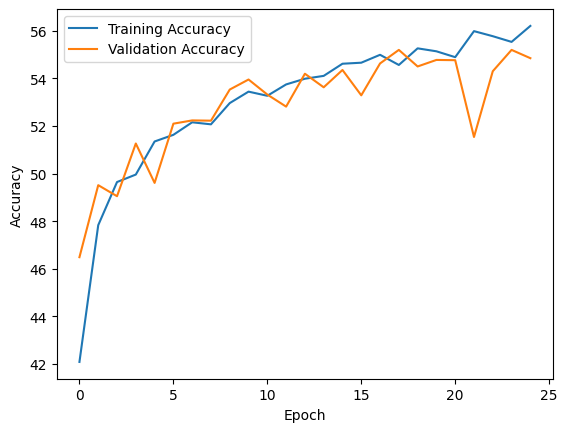

In [17]:
trainset = MelSpectrogramDataset(
    csv_file=train_csv, root_dir=root_dir, transform=train_transform)
valset = MelSpectrogramDataset(
    csv_file=val_csv, root_dir=root_dir, transform=test_transform)
testset = MelSpectrogramDataset(
    csv_file=test_csv, root_dir=root_dir, transform=test_transform)

trainloader = DataLoader(trainset, batch_size=128,
                         shuffle=True, num_workers=8, pin_memory=True)
valloader = DataLoader(valset, batch_size=128,
                       shuffle=False, num_workers=8, pin_memory=True)
testloader = DataLoader(testset, batch_size=128,
                        shuffle=False, num_workers=8, pin_memory=True)

# Label mappings
labelmap = trainset.label_map
print(f"Mapping from Emotion to Number: {labelmap}")

print(f"Model is on: {next(model.parameters()).device}")
model, train_losses, train_accuracies, val_losses, val_accuracies = train_epochs(
    model, trainloader, valloader, criterion, optimizer, device, epochs)
torch.save(model.state_dict(), f'{FINETUNED_MODEL}_variables_{epochs}.pt')

# Plots
plot_loss(train_losses, val_losses)
plot_accuracy(train_accuracies, val_accuracies)

Define the function to plot the confusion matrix


In [18]:
import seaborn as sns
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(y_true, y_pred):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Create figure and axes
    plt.figure(figsize=(10, 8))

    # Create heatmap
    sns.heatmap(cm,
                annot=True,  # Show numbers in cells
                fmt='d',     # Use integer formatting
                cmap='Blues',  # Color scheme
                xticklabels=trainset.label_map.keys(),
                yticklabels=trainset.label_map.keys())

    # Set labels and title
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')

    # Rotate axis labels for better readability
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)

    plt.tight_layout()
    plt.show()

Define the function to evaluate the best model on the test set


In [19]:
def load_and_evaluate_best_model(model, testloader, criterion, device, model_path):
    # Load the best model weights
    model.load_state_dict(torch.load(model_path))
    model.eval()

    all_preds = []
    all_labels = []
    running_loss = 0.0
    correct = 0
    total = 0

    print("Evaluating best model on test set...")
    with torch.no_grad():
        for inputs, labels in tqdm(testloader, desc='Testing'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            # Calculate loss
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Store predictions for confusion matrix
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate final metrics
    test_loss = running_loss / len(testloader)
    test_accuracy = 100 * correct / total

    print(f"\nTest Results (Best Model):")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.2f}%")

    return test_loss, test_accuracy, all_preds, all_labels

Evaluate the best model on the test set


C:\Users\profi\AppData\Local\Temp\ipykernel_30564\3579996063.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Evaluating best model on test set...


Testing: 100%|██████████| 75/75 [00:22<00:00,  3.34it/s]


Test Results (Best Model):
Test Loss: 1.1584
Test Accuracy: 55.26%


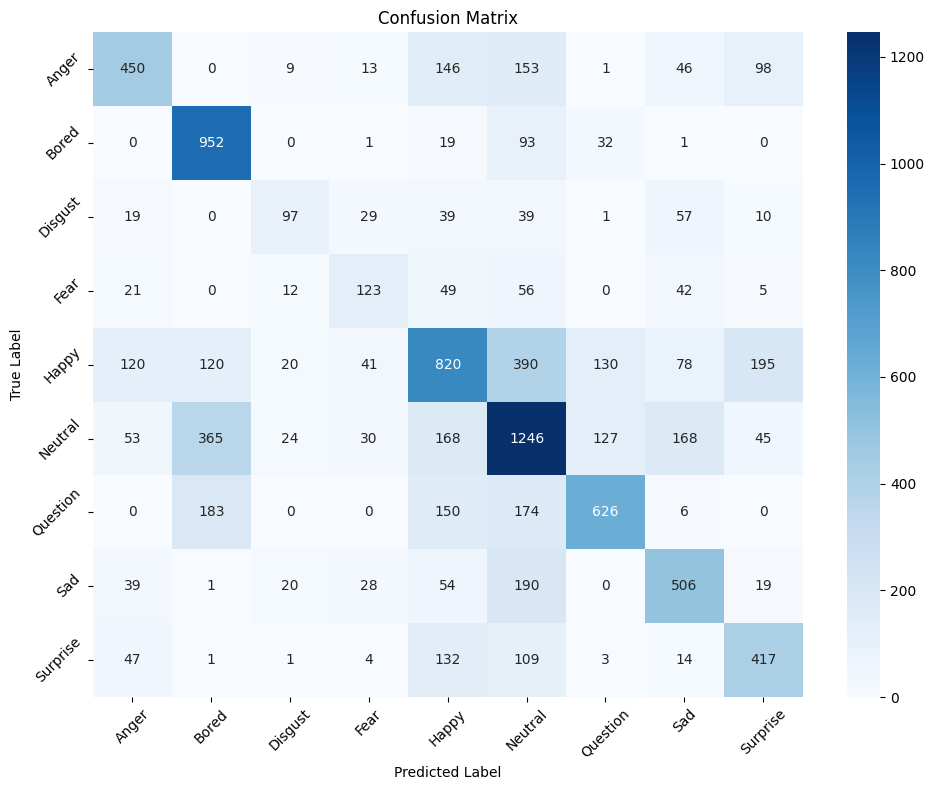

In [20]:
# Load and evaluate the best model
best_model_path = f'best_{FINETUNED_MODEL}.pt'
test_loss, test_accuracy, all_preds, all_labels = load_and_evaluate_best_model(
    model=model,
    testloader=testloader,
    criterion=criterion,
    device=device,
    model_path=best_model_path
)

# Plot confusion matrix
plot_confusion_matrix(all_labels, all_preds)